In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
import random

# Sklearn Imports
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, PowerTransformer, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture
from sklearn.cluster import (
    KMeans,
    AgglomerativeClustering,
    DBSCAN,
    MeanShift,
    SpectralClustering,
    estimate_bandwidth
)
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score
)


In [52]:
warnings.filterwarnings("ignore")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

In [53]:
# Configuration for Clusters
target_k = 3

In [54]:
df = pd.read_csv("/content/cleaned_dataset.csv")


In [55]:
cols_to_drop = ['cluster_kmeans', 'Number of Records', 'Country']
df_clean = df.drop(columns=[c for c in cols_to_drop if c in df.columns], errors='ignore')

In [56]:
# Create df_model from your cleaned data first
df_model = df_clean.copy()

In [57]:
# Keep GDP for profiling but drop from model if present
if 'GDP' in df_model.columns:
    df_for_profile = df_model.copy()
    df_model = df_model.drop(columns=['GDP'])
else:
    df_for_profile = df_model.copy()

In [58]:
# Identify numeric features
feature_cols = df_model.select_dtypes(include=np.number).columns.tolist()

In [59]:
# Numeric columns only
num_col = df_model.select_dtypes(include=np.number).columns.tolist()
if len(num_col) == 0:
    raise RuntimeError("No numeric features found for clustering. Check data.")
feature_cols = num_col.copy()


# PIPELINE: IMPUTE -> SCALE -> POWER -> PCA
imputer = SimpleImputer(strategy='median')
scaler = RobustScaler()
pt = PowerTransformer(method='yeo-johnson')
pca = PCA(n_components=0.85, svd_solver='full')  # changeable parameter

pipe = Pipeline([
    ('imputer', imputer),
    ('scaler', scaler),
    ('power', pt),
    ('pca', pca)
])

X = df_model[feature_cols].values
X_transformed = pipe.fit_transform(X)



In [60]:
print(f"Data Prepared. Features: {len(feature_cols)}, PCA Components: {X_transformed.shape[1]}")

Data Prepared. Features: 22, PCA Components: 8


In [61]:
# A dictionary to hold model configurations
models = {}

In [62]:
# 1. KMeans
models['KMeans'] = KMeans(n_clusters=target_k, random_state=RANDOM_STATE, n_init=50)

# 2. Agglomerative (Hierarchical)
models['Agglomerative'] = AgglomerativeClustering(n_clusters=target_k)

# 3. Gaussian Mixture (GMM)
models['GaussianMixture'] = GaussianMixture(n_components=target_k, random_state=RANDOM_STATE, n_init=5)

# 4. Spectral Clustering
models['Spectral'] = SpectralClustering(n_clusters=target_k, assign_labels='discretize', random_state=RANDOM_STATE)

# 5. MeanShift (Bandwidth estimation is key)
bandwidth = estimate_bandwidth(X_transformed, quantile=0.2, n_samples=len(X_transformed))
models['MeanShift'] = MeanShift(bandwidth=bandwidth, bin_seeding=True)

# 6. DBSCAN (Dynamic Epsilon calculation)
# We calculate a suggested eps based on NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=5).fit(X_transformed)
distances, _ = nbrs.kneighbors(X_transformed)
dist_k = np.sort(distances[:, -1])
suggested_eps = float(np.percentile(dist_k, 90) * 0.9)  # Heuristic
eps_final = suggested_eps if suggested_eps > 0 else 0.5
models['DBSCAN'] = DBSCAN(eps=eps_final, min_samples=5)

In [63]:
# --- 6. TRAINING & EVALUATION LOOP ---
results = []
prediction_storage = {}

print("\n--- Model Evaluation In Progress ---")

for name, model in models.items():
    try:
        if name == 'GaussianMixture':
            labels = model.fit_predict(X_transformed)
        else:
            labels = model.fit_predict(X_transformed)

        prediction_storage[name] = labels

        n_labels = len(set(labels))
        if n_labels > 1:
            sil = silhouette_score(X_transformed, labels)
            db = davies_bouldin_score(X_transformed, labels)
            ch = calinski_harabasz_score(X_transformed, labels)
        else:
            sil, db, ch = -1, -1, -1

        results.append({
            'Model': name,
            'Silhouette': sil,
            'Davies-Bouldin': db,
            'Calinski-Harabasz': ch
        })
    except Exception as e:
        print(f"Failed: {name} - {str(e)}")

results_df = pd.DataFrame(results).sort_values(by='Silhouette', ascending=False)
display(results_df)


--- Model Evaluation In Progress ---


,Model,Silhouette,Davies-Bouldin,Calinski-Harabasz
0,KMeans,0.271228,1.354214,1439.014160
1,Agglomerative,0.236563,1.311695,1228.152927
2,GaussianMixture,0.063944,2.366384,542.717393
3,Spectral,0.039475,1.335390,33.244541
5,DBSCAN,-0.250057,1.504925,13.213934
4,MeanShift,-1.000000,-1.000000,-1.000000


In [64]:
#  BEST MODEL SELECTION
best_model_name = results_df.iloc[0]['Model']
best_model_instance = models[best_model_name]
best_metrics = results_df.iloc[0].to_dict()

print(f"Saving deployment bundle for: {best_model_name}")


Saving deployment bundle for: KMeans


In [65]:
# Use 'X_transformed' instead of 'X_scaled'
kmeans.fit(X_transformed)

# Now get the labels
best_labels = kmeans.labels_

# Attach to your dataframe
df_for_profile['Cluster'] = best_labels


Generating PCA Grid Plot...


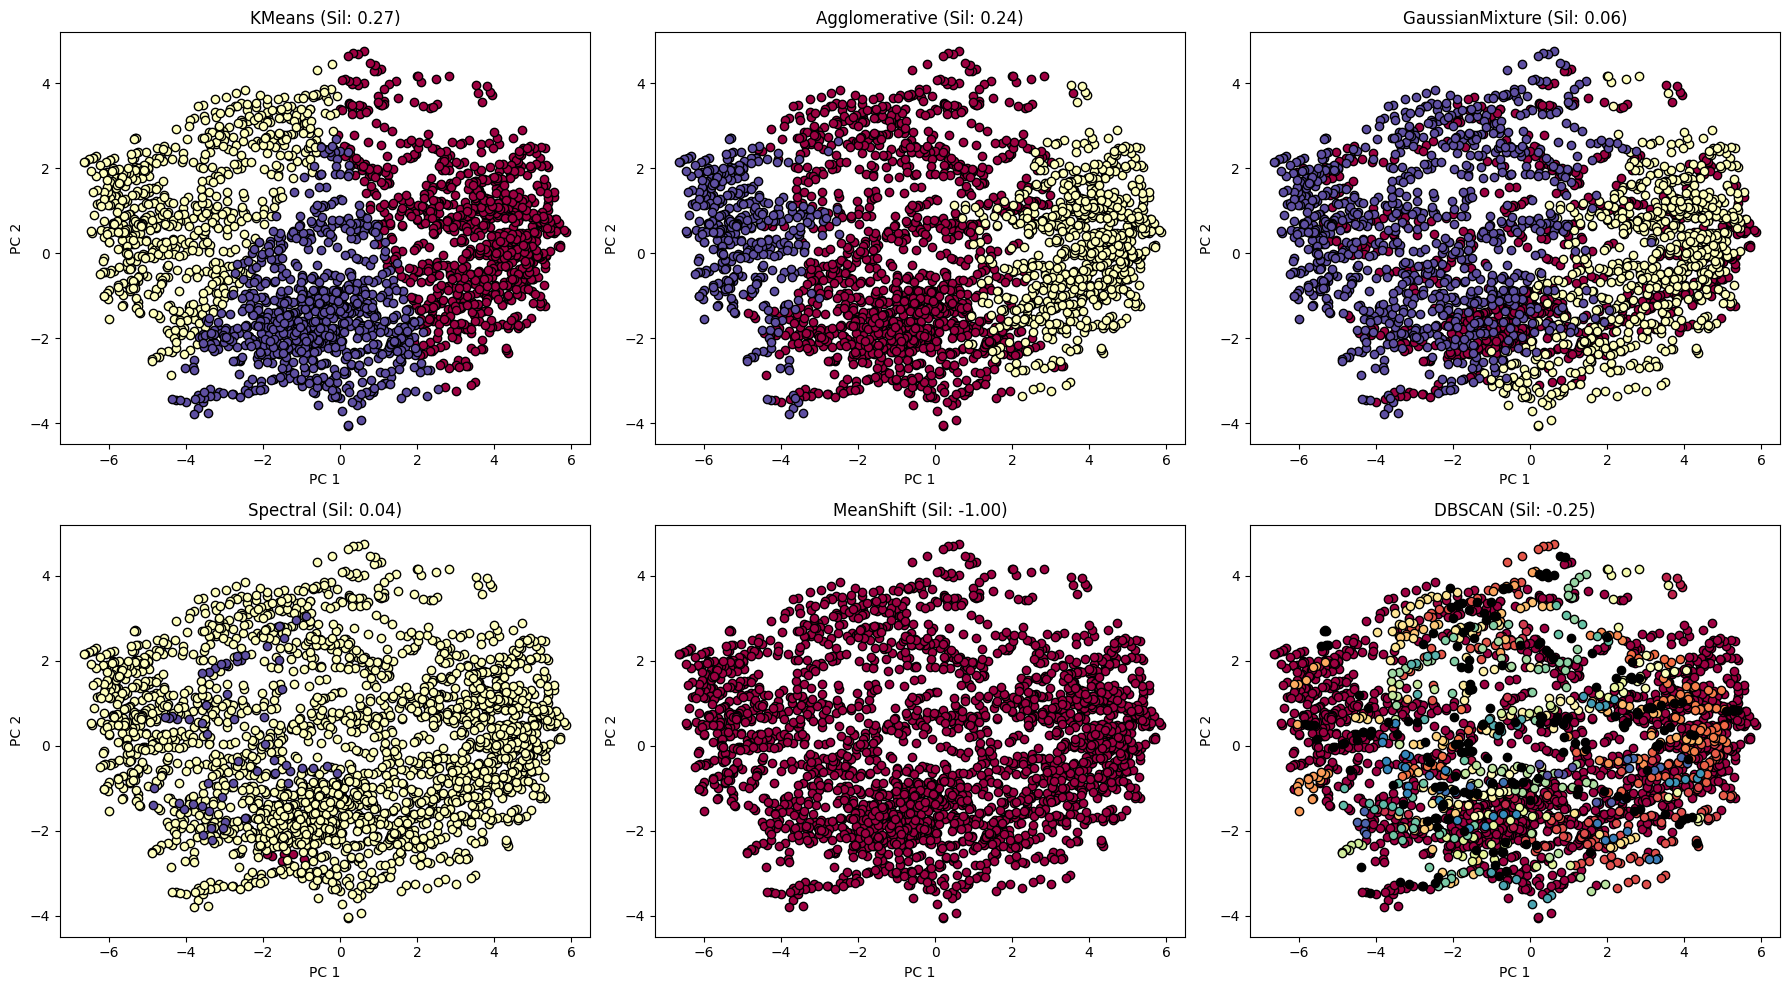

In [66]:
#  VISUALIZATION 1: PCA GRID PLOT
print("\nGenerating PCA Grid Plot...")
n_models = len(models)
cols = 3
rows = (n_models + cols - 1) // cols
plt.figure(figsize=(18, 5 * rows))

for i, (name, labels) in enumerate(prediction_storage.items()):
    plt.subplot(rows, cols, i + 1)
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1: col = [0, 0, 0, 1]
        class_member_mask = (labels == k)
        xy = X_transformed[class_member_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6, label=f'Cluster {k}')
    plt.title(f"{name} (Sil: {results_df[results_df['Model']==name]['Silhouette'].values[0]:.2f})")
    plt.xlabel('PC 1'); plt.ylabel('PC 2')
plt.tight_layout()
plt.show()


Generating Boxplots for Key Metrics...


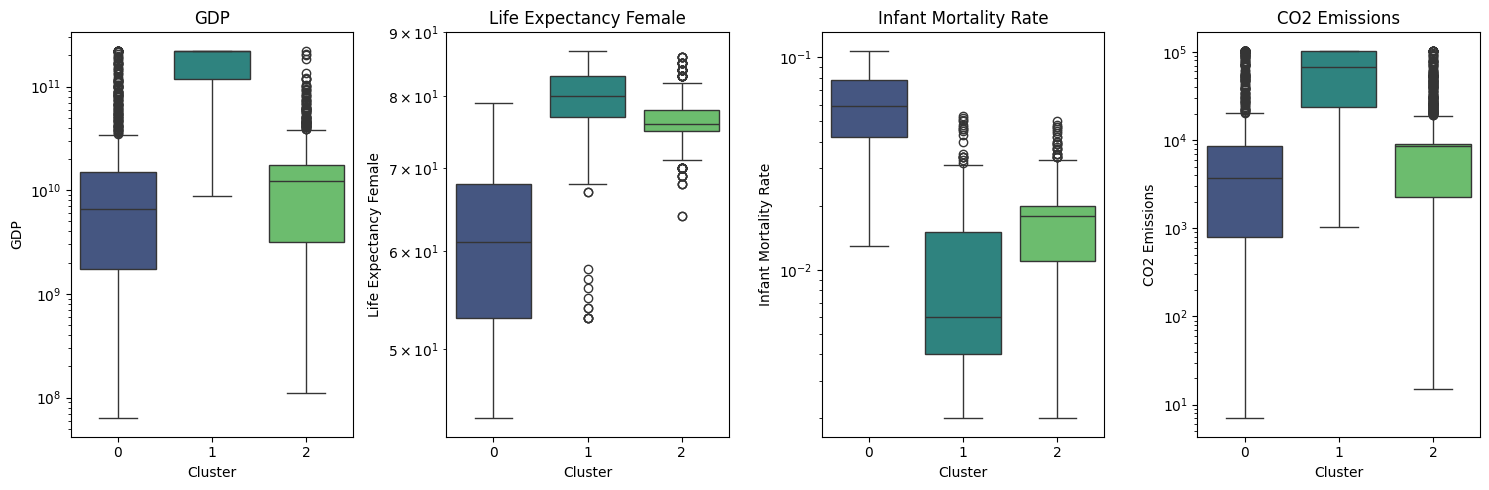

In [67]:
#  VISUALIZATION 2: BOXPLOTS OF KEY METRICS
print("\nGenerating Boxplots for Key Metrics...")
key_features = ['GDP', 'Life Expectancy Female', 'Infant Mortality Rate', 'CO2 Emissions']
# Filter to only existing columns
key_features = [c for c in key_features if c in df_for_profile.columns]

if key_features:
    plt.figure(figsize=(15, 5))
    for i, col in enumerate(key_features):
        plt.subplot(1, len(key_features), i+1)
        sns.boxplot(x='Cluster', y=col, data=df_for_profile, palette='viridis')
        plt.title(col)
        plt.yscale('log') # Log scale helps visualization if outliers exist
    plt.tight_layout()
    plt.show()


Generating Cluster Interpretation Heatmap...


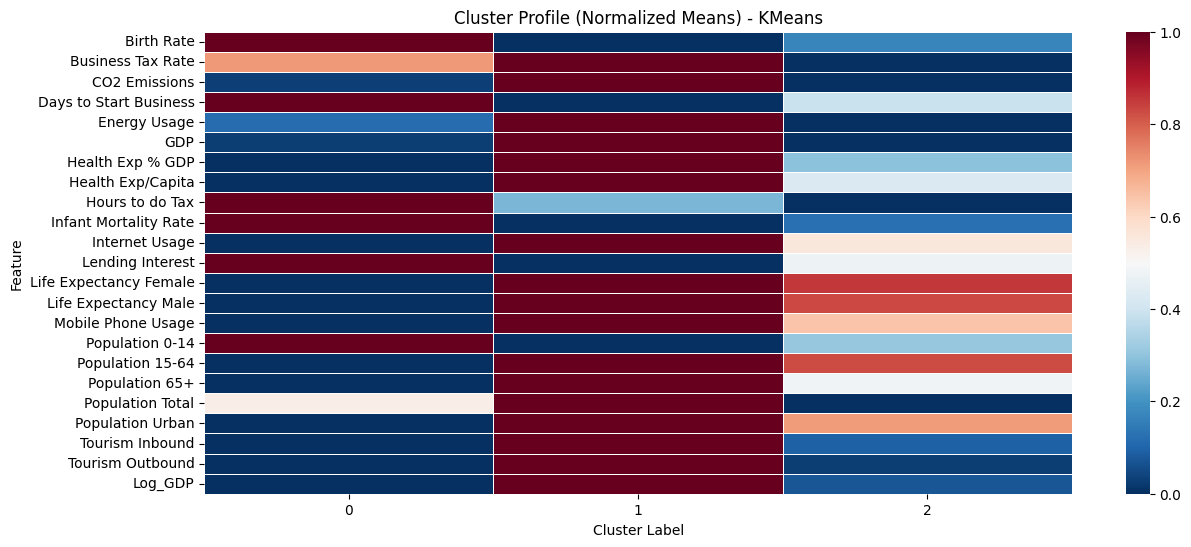

In [68]:
#  VISUALIZATION 3: CLUSTER PROFILING (HEATMAP)
print("\nGenerating Cluster Interpretation Heatmap...")
# Calculate mean of features per cluster
cluster_means = df_for_profile.groupby('Cluster').mean(numeric_only=True)

# Normalize for heatmap (0-1 scale) so we can compare different units
scaler_viz = MinMaxScaler()
cluster_means_scaled = pd.DataFrame(scaler_viz.fit_transform(cluster_means),
                                    columns=cluster_means.columns,
                                    index=cluster_means.index)

plt.figure(figsize=(14, 6))
sns.heatmap(cluster_means_scaled.T, cmap="RdBu_r", center=0.5, annot=False, linewidths=.5)
plt.title(f"Cluster Profile (Normalized Means) - {best_model_name}")
plt.xlabel("Cluster Label")
plt.ylabel("Feature")
plt.show()

In [69]:
deployment_bundle = {
    "pipeline": pipe,                 # The preprocessing pipeline (Imputer -> Scaler -> PCA)
    "model": best_model_instance,     # The actual best clustering model object
    "feature_cols": feature_cols,     # List of columns used
    "best_model_name": best_model_name,
    "training_metrics": best_metrics,
    "description": f"Best clustering model ({best_model_name}) selected via silhouette score."
}

# 3. Save it
joblib.dump(deployment_bundle, "best_clustering_model.joblib")
print(f"SUCCESS: Model saved as 'best_clustering_model.joblib'")

SUCCESS: Model saved as 'best_clustering_model.joblib'


In [70]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import joblib

# 1. Define and Train the final model
# (We re-train it here to ensure 'kmeans_final' exists and is fitted)
optimal_K = 3  # Based on your project settings
kmeans_final = KMeans(n_clusters=optimal_K, random_state=42, n_init=10)
kmeans_final.fit(X_transformed)

# 2. Get labels and metrics
labels = kmeans_final.labels_
sil = silhouette_score(X_transformed, labels)
db_score = davies_bouldin_score(X_transformed, labels)
ch_score = calinski_harabasz_score(X_transformed, labels)

# 3. Create the deployment bundle
deployment_bundle = {
    "pipeline": pipe,                # imputer + scaler + power + PCA
    "model": kmeans_final,           # The trained KMeans model
    "feature_cols": feature_cols,    # numeric feature list
    "optimal_k": optimal_K,
    "training_metrics": {
        "silhouette": float(sil),
        "davies_bouldin": float(db_score),
        "calinski_harabasz": float(ch_score),
    },
    "description": f"KMeans clustering pipeline (k={optimal_K}) for global development",
}

# 4. Save the file
joblib.dump(deployment_bundle, "development_cluster_pipeline_kmeans.joblib")
print("✅ Success! 'development_cluster_pipeline_kmeans.joblib' has been saved.")

✅ Success! 'development_cluster_pipeline_kmeans.joblib' has been saved.


In [71]:

df_for_profile.to_csv('clustered_data.csv', index=True, index_label="Country")

print("✅ Success! File saved with Country names.")
print(df_for_profile.head())

✅ Success! File saved with Country names.
   Birth Rate  Business Tax Rate  CO2 Emissions  Days to Start Business  \
0       0.020               0.41        87931.0                    26.0   
1       0.050               0.41         9542.0                    26.0   
2       0.043               0.41         1617.0                    26.0   
3       0.027               0.41         4276.0                    26.0   
4       0.046               0.41         1041.0                    26.0   

   Energy Usage           GDP  Health Exp % GDP  Health Exp/Capita  \
0       26998.0  5.479006e+10             0.035               60.0   
1        7499.0  9.129595e+09             0.034               22.0   
2        1983.0  2.359122e+09             0.043               15.0   
3        1836.0  5.788312e+09             0.047              152.0   
4       14338.0  2.610959e+09             0.051               12.0   

   Hours to do Tax  Infant Mortality Rate  ...  Mobile Phone Usage  \
0            239